<a href="https://colab.research.google.com/github/zakirangwala/esrb-wizard/blob/main/notebooks/workingFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Do Players Prefer Games with Mature Content?**

#1. Data Cleanse & Preprocessing

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn
import ast

## Data Cleanse & Preprocessing

In [2]:
# loading the dataset (originally from https://www.kaggle.com/datasets/fronkongames/steam-games-dataset; had to manually add a comma to separate Discount and DLC)
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/CP322/games.csv" # save to github: notebooks/workingFile.ipynb
steam = pd.read_csv(path, index_col=False)
steam.head()

Mounted at /content/drive


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,Discount,DLC count,About the game,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [3]:
# First check that all AppID columns are unique in order to ensure no games listed twice
steam = steam.dropna(subset=['AppID', 'Name'])
print("Dataset Dimensions: ", steam.shape)
print("Unique columns in 'AppID': ", steam['AppID'].nunique())
print("Unique columns in 'Name': ", steam['Name'].nunique())

Dataset Dimensions:  (111446, 40)
Unique columns in 'AppID':  111446
Unique columns in 'Name':  110325


We first drop missing rows since they're both unique identifiers and it's not possible to impute those values. Since the shape and the number of unique rows in AppID are exact, we know that we are not double counting a game. But we notice that there are repeat values in name - this is because some games become region-locked and are only avaiable to play in certain countries. In some cases, there are multiple versions that exist so that. Should we cut these?

In [4]:
# Dropping uneccessary columns
steam_drop = steam.drop(['AppID', 'Discount', 'About the game', 'Reviews',
                        'Header image','Tags','Website', 'Support url',
                        'Support email','Metacritic url', 'Score rank', 'Notes',
                        'Developers', 'Screenshots', 'Movies',
                        ], axis=1)
steam_drop.head()

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,Supported languages,Full audio languages,Windows,...,Negative,Achievements,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Publishers,Categories,Genres
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,['English'],[],True,...,11,30,0,0,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports"
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,5,12,0,0,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie"
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,"['English', 'Portuguese - Brazil']",[],True,...,0,0,0,0,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy"
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,0,0,0,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie"
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,"['English', 'Spanish - Spain']",[],True,...,8,17,0,0,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie"


dropping those columns (either it's a unique identifier that we don't need, heavy text based, images of the game, contact information, or ambiguous meaning, or info players would not have access to without Google. Or in the case of discount doesn't impact how a player will play just if they will purchase a game)

In [5]:
steam_drop['release_year'] = (steam_drop['Release date'].str.split(',').str[1]).astype('category')
steam_drop['Required age'] = steam_drop['Required age'].astype('category')
steam_drop = steam_drop.drop(['Release date'], axis=1)
steam_drop.head()

,Name,Estimated owners,Peak CCU,Required age,Price,DLC count,Supported languages,Full audio languages,Windows,Mac,...,Achievements,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Publishers,Categories,Genres,release_year
0,Galactic Bowling,0 - 20000,0,0,19.99,0,['English'],[],True,False,...,30,0,0,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008
1,Train Bandit,0 - 20000,0,0,0.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,...,12,0,0,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017
2,Jolt Project,0 - 20000,0,0,4.99,0,"['English', 'Portuguese - Brazil']",[],True,False,...,0,0,0,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",2021
3,Henosis™,0 - 20000,0,0,5.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,...,0,0,0,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie",2020
4,Two Weeks in Painland,0 - 20000,0,0,0.00,0,"['English', 'Spanish - Spain']",[],True,True,...,17,0,0,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie",2020


XGBoost and Random Forests cannot work with the date directly. Instead, we take the release year (what is usually mentioned when games are discussed. Months and days are rarely relevant)

In [6]:
print("Unique columns in 'Estimated owners': ", steam_drop['Estimated owners'].nunique())
#print(steam_drop['Estimated owners'].unique())

owners_mapping = {
    '0 - 0': 0,
    '0 - 20000': 10000,
    '20000 - 50000': 35000,
    '50000 - 100000': 75000,
    '100000 - 200000': 150000,
    '200000 - 500000': 350000,
    '500000 - 1000000': 750000,
    '1000000 - 2000000': 1500000,
    '2000000 - 5000000': 3500000,
    '5000000 - 10000000': 7500000,
    '10000000 - 20000000': 15000000,
    '20000000 - 50000000': 35000000,
    '50000000 - 100000000': 75000000,
    '100000000 - 200000000': 150000000
}

steam_drop['midpoint_estimated_owners'] = steam_drop['Estimated owners'].map(owners_mapping)
steam_drop= steam_drop.drop(['Estimated owners'], axis=1) # we have a better column now

print("Unique columns in 'midpoint_estimated_owners': ", steam_drop['midpoint_estimated_owners'].nunique())
#print(steam_drop['midpoint_estimated_owners'].unique())
print("Dataframe size after taking midpoint of estimated owner size range", steam_drop.shape)

Unique columns in 'Estimated owners':  14
Unique columns in 'midpoint_estimated_owners':  14
Dataframe size after taking midpoint of estimated owner size range (111446, 25)


Using a midpoint for the estimated number of ownsers gives a much better representation for what the sales look like compared to have categorical values.

In [7]:
print("Unique columns in 'Required age': ", steam_drop['Required age'].nunique())
#print(steam_drop['Required age'].unique())

def age_mapping(x):
  if 0 <= x < 10         : return 0
  elif 10 <= x < 13      : return 10
  elif 13 <= x < 17      : return 13
  elif x >= 17           : return 17


steam_drop['esrb_age']=steam_drop['Required age'].apply(age_mapping)
steam_drop= steam_drop.drop(['Required age'], axis=1).astype('category') # we have a better column now

print("Unique columns in 'esrb_age': ", steam_drop['esrb_age'].nunique())
print("Dataframe size after transforming age categories to match ESRB recommended ages", steam_drop.shape)

Unique columns in 'Required age':  19
Unique columns in 'esrb_age':  4
Dataframe size after transforming age categories to match ESRB recommended ages (111446, 25)


Using the ESRB ratings ages instead because in practice, most people would recommend games via these ages and not super specific ones. Most people would say good for a child, pre-teen, teen or adult. No need to consider the AO since most retailers want their games to be able to be sold in any storefront and AO ratings prevent this.

In [8]:
print("Dataframe size before dropping non-english games", steam_drop.shape)

steam_drop = steam_drop[steam_drop['Supported languages'].apply(lambda x: 'English' in x)]
steam_drop = steam_drop.drop(['Supported languages'], axis=1) # no longer need it if all games are english

print("Dataframe size after dropping non-english games", steam_drop.shape)

steam_drop = steam_drop[steam_drop['Full audio languages'].apply(lambda x: (len(x) == 2 or 'English' in x))]
# if we make this 0, we could have 40000 rows of only english voice acting games

steam_drop['voice_acting'] = steam_drop['Full audio languages'].apply(lambda x: 0 if len(x) == 2 else 1).astype('category')
# 0 means no, 1 means yes it has voice acting
steam_drop = steam_drop.drop(['Full audio languages'], axis=1)

print("Dataframe size after dropping games that have audio exclusively in another language", steam_drop.shape)
steam_drop.tail()

Dataframe size before dropping non-english games (111446, 25)
Dataframe size after dropping non-english games (99911, 24)
Dataframe size after dropping games that have audio exclusively in another language (97272, 24)


,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Publishers,Categories,Genres,release_year,midpoint_estimated_owners,esrb_age,voice_acting
111447,Paragon Of Time,0,2.99,0,True,False,False,0,0,5,...,0,0,0,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie",2025,10000,0,0
111448,A Few Days With : Hazel,0,2.69,0,True,False,False,0,0,0,...,0,0,0,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie",2025,10000,0,0
111449,MosGhost,0,7.99,0,True,False,False,0,0,24,...,0,0,0,"Sinka Games,Arkuda Inc.","Single-player,Family Sharing",Simulation,2025,10000,0,0
111450,AccuBow VR,0,0.00,0,True,False,False,0,0,0,...,0,0,0,AccuBow LLC,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play",2025,0,0,1
111451,Defense Of Fort Burton,0,9.99,0,True,False,False,0,0,0,...,0,0,0,Ledx,"Single-player,Steam Achievements,Steam Cloud,S...","Action,Casual,Strategy,Early Access",2025,10000,0,1


Being a North American independent rating company, ESRB usually only rates English games. Thus, we are interested in looking at games that support both English text and only games that either have English voice acting or no voice acting (audio we transform into a categorical value on if it contains voice acting or not). Plus, there have only ever been 24 games ever given the AO rating (https://en.wikipedia.org/wiki/List_of_AO-rated_video_games)

In [9]:
boolean_mapping = {
    True: 1,
    False: 0
}

steam_drop['Windows'] = steam_drop['Windows'].map(boolean_mapping).astype('category')
steam_drop['Mac'] = steam_drop['Mac'].map(boolean_mapping).astype('category')
steam_drop['Linux'] = steam_drop['Linux'].map(boolean_mapping).astype('category')

steam_drop.head()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Publishers,Categories,Genres,release_year,midpoint_estimated_owners,esrb_age,voice_acting
0,Galactic Bowling,0,19.99,0,1,0,0,0,0,6,...,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008,10000,0,0
1,Train Bandit,0,0.99,0,1,1,0,0,0,53,...,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017,10000,0,0
2,Jolt Project,0,4.99,0,1,0,0,0,0,0,...,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",2021,10000,0,0
3,Henosis™,0,5.99,0,1,1,1,0,0,3,...,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie",2020,10000,0,0
4,Two Weeks in Painland,0,0.00,0,1,1,0,0,0,50,...,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie",2020,10000,0,0


In [10]:
# Attempting to show the relationship between how many reviews are positive vs negative in a game
steam_drop['Positive'] = steam_drop['Positive'].astype(int)
steam_drop['Negative'] = steam_drop['Negative'].astype(int)
steam_drop['%_positive_reviews'] = ((steam_drop['Positive'])/(steam_drop['Positive']+ steam_drop['Negative']) * 100).fillna(0)
steam_drop.head()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Median playtime forever,Median playtime two weeks,Publishers,Categories,Genres,release_year,midpoint_estimated_owners,esrb_age,voice_acting,%_positive_reviews
0,Galactic Bowling,0,19.99,0,1,0,0,0,0,6,...,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008,10000,0,0,35.294118
1,Train Bandit,0,0.99,0,1,1,0,0,0,53,...,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017,10000,0,0,91.379310
2,Jolt Project,0,4.99,0,1,0,0,0,0,0,...,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",2021,10000,0,0,0.000000
3,Henosis™,0,5.99,0,1,1,1,0,0,3,...,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie",2020,10000,0,0,100.000000
4,Two Weeks in Painland,0,0.00,0,1,1,0,0,0,50,...,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie",2020,10000,0,0,86.206897


In [11]:
# Working to transform categorical list columns via multilabel encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Working with the Genres
steam_drop['Genres'] = steam_drop['Genres'].astype(object)
genres = steam_drop[['Name','Genres']].copy()
genres['Genres'] = genres['Genres'].fillna('').apply(lambda x: [g.strip() for g in x.split(',')] if x else [])

genres_encoded = pd.DataFrame(mlb.fit_transform(genres['Genres']),columns=mlb.classes_, index=genres.index)
genres = pd.concat([genres[['Name']], genres_encoded], axis=1)
genres['Free to Play'] = (genres['Free to Play'] != 0) | (genres['Free To Play'] != 0)
genres = genres.drop(['Free To Play'], axis=1) # we had duplicate columns

# Working with the Categories
steam_drop['Categories'] = steam_drop['Categories'].astype(object)
categories = steam_drop[['Name','Categories']].copy()
categories['Categories'] = categories['Categories'].fillna('').apply(lambda x: [g.strip() for g in x.split(',')] if x else [])

categories_encoded = pd.DataFrame(mlb.fit_transform(categories['Categories']),columns=mlb.classes_, index=categories.index)
categories = pd.concat([categories[['Name']], categories_encoded], axis=1)

# Merging new datasets back into the Steam dataset
steam_encoded = pd.merge(steam_drop, genres, on='Name', how='inner')
steam_encoded = pd.merge(steam_encoded, categories, on='Name', how='inner')
steam_encoded = steam_encoded.drop(['Genres', 'Categories'], axis=1)
steam_encoded.head()

#genres_encoded.columns.tolist()
#categories_encoded.columns.tolist()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,Tracked Motion Controller Support,VR Only,VR Support,VR Supported,Valve Anti-Cheat enabled
0,Galactic Bowling,0,19.99,0,1,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,Train Bandit,0,0.99,0,1,1,0,0,0,53,...,0,0,0,0,0,0,0,0,0,0
2,Jolt Project,0,4.99,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Henosis™,0,5.99,0,1,1,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4,Two Weeks in Painland,0,0.00,0,1,1,0,0,0,50,...,0,0,0,0,0,0,0,0,0,0


Well we wanted to create encoding to see if any of the genres or categories play an important role. But they were original strings. We had to first convert to arrays by splitting on the comma, and then transforming each unique value into a column. There's so many here... maybe we drop the ones that don't make sense

## Feature Engineering

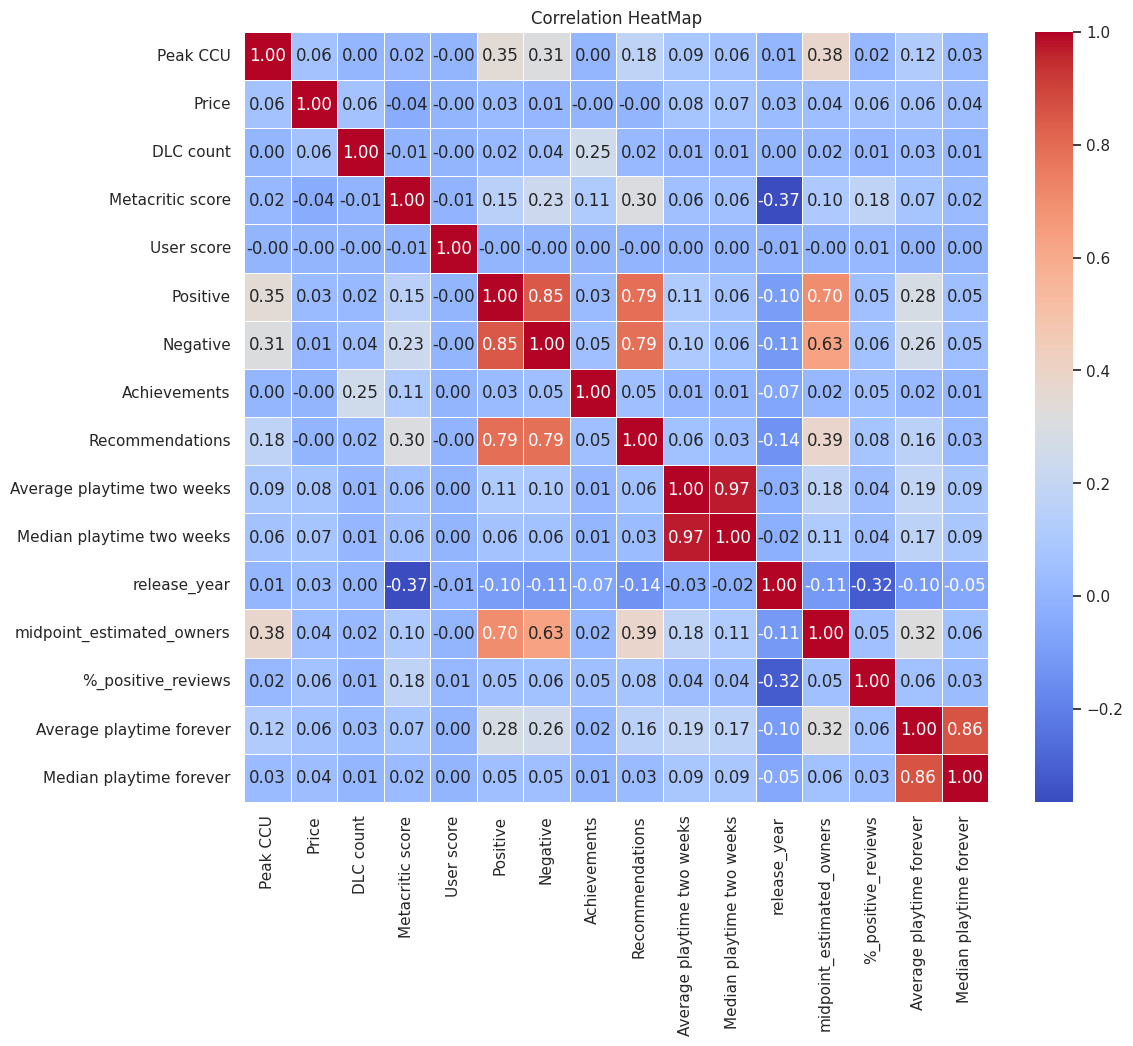

In [13]:
# Testing for Multicolinearity on Numerical Columns
steam_numerical = steam_encoded[['Peak CCU','Price','DLC count','Metacritic score',
                                 'User score','Positive','Negative','Achievements',
                                 'Recommendations','Average playtime two weeks',
                                 'Median playtime two weeks','release_year',
                                 'midpoint_estimated_owners','%_positive_reviews'
                                 ]]

correlation_matrix = steam_numerical.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation HeatMap')
plt.show()

In [15]:
# New variable to show if a game has ever been played before
def play_mapping(x):
  if x == 0            : return 0
  elif x > 0           : return 1

steam_encoded['played_before'] = steam_encoded['Average playtime forever'].apply(play_mapping)
steam_encoded.tail()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,Tracked Motion Controller Support,VR Only,VR Support,VR Supported,Valve Anti-Cheat enabled,played_before
113773,Paragon Of Time,0,2.99,0,1,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
113774,A Few Days With : Hazel,0,2.69,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113775,MosGhost,0,7.99,0,1,0,0,0,0,24,...,0,0,0,0,0,0,0,0,0,0
113776,AccuBow VR,0,0.00,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
113777,Defense Of Fort Burton,0,9.99,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


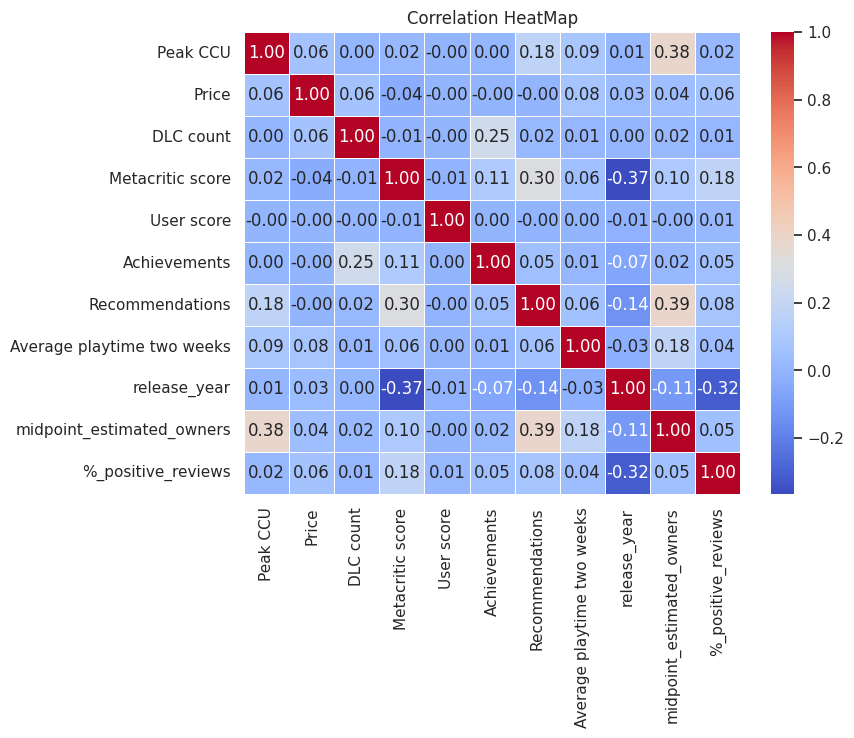

In [20]:
# Testing for Multicolinearity after Dropping Problematic Columns
steam_encoded = steam_encoded.drop(['Positive', 'Negative', 'Median playtime two weeks',
                                    'Average playtime forever', 'Median playtime forever'], axis=1)

steam_numerical = steam_encoded[['Peak CCU','Price','DLC count','Metacritic score',
                                 'User score','Achievements','Recommendations',
                                 'Average playtime two weeks','release_year',
                                 'midpoint_estimated_owners','%_positive_reviews']]
correlation_matrix = steam_numerical.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation HeatMap')
plt.show()

This graphic shows that there is a strong relationship between positive reviews, negative reviews and recommendations. Since %_positive_reviews is just the percentage of positive reviews out of all reviews, it captures both columns. And recommendations is just how many people would recommend the game to someone else, which is also going to be highly tied to those who give it positive reviews. We can cut the positive and negative columns since the purpose of them is essentially captured by the %_positive and recommendations columns

We also need to drop one of average and median playtime. Which makes sense. We choose to drop median and make average our response variate.

Dropping these 3 columns fixes our multicolinearity.


In [21]:
#dropping na values
steam_clean = steam_encoded.dropna()
print("Dataset size before dropping na values", steam_encoded.shape)
print("Dataset size after dropping na values", steam_clean.shape)

pd.DataFrame(steam_clean).to_csv("/content/drive/MyDrive/CP322/steam_clean.csv", index=False)

Dataset size before dropping na values (113778, 95)
Dataset size after dropping na values (113132, 95)


We can do this because we lose ~2% of our data. It's so minial and still leaves us with over 110000 entries, so it's fine to cut

#2. Breadth Component

In [22]:
# loading the dataset (originally from https://www.kaggle.com/datasets/imohtn/video-games-rating-by-esrb)

path2 = "/content/drive/MyDrive/CP322/ESRB.csv" # save to github: notebooks/steamDataCleanse.ipynb
esrb = pd.read_csv(path2, index_col=False)
esrb.head()

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


In [23]:
# Cleaning the ESRB dataset and enforcing Integer values
esrb_clean = esrb.dropna()
esrb_clean = esrb_clean.drop(['console'], axis=1)
print("Dataset size before dropping na values", esrb_clean.shape)

cols = esrb_clean.columns[1:32]
esrb_clean[cols] = esrb_clean[cols].astype(int)

print("Dataset size after dropping na values", esrb_clean.shape)

esrb_clean.head()

Dataset size before dropping na values (1895, 33)
Dataset size after dropping na values (1895, 33)


,title,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,T


In attempting to clean the data we see that there are no missing values at all. We drop 'console' since ratings don't vary by console and since the steam dataset already captures this. Then we enforce that all remaining columns (except ESRB rating) are integer so they can be treated as categorical columns

In [24]:
pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.1 MB/s eta 0:00:00


In [42]:
# Merging the Two Datasets by Suing Fuzzy Matching
import pandas as pd
from rapidfuzz import process, fuzz

df = steam_clean.copy()
df['Name'] = df['Name'].astype(str)
esrb_clean['title'] = esrb_clean['title'].astype(str)

query_list = df['Name'].tolist()
choices_list = esrb_clean['title'].tolist()

# Compute all similarity scores (matrix of shape len(df) x len(esrb_clean))
scores_matrix = process.cdist(
    query_list,
    choices_list,
    scorer=fuzz.ratio,
    workers=-1
)

scores_matrix = np.array(scores_matrix)

# Find index of best match for each query
best_match_idx = scores_matrix.argmax(axis=1)

# Find the corresponding best score
best_scores = scores_matrix.max(axis=1)

threshold = 84.5  # minimum score to consider a match
best_scores_masked = np.where(best_scores >= threshold, best_scores, np.nan)
best_match_idx_masked = np.where(best_scores >= threshold, best_match_idx, np.nan)

best_matches = [choices_list[int(idx)] if not np.isnan(idx) else np.nan for idx in best_match_idx_masked]

df['join_key'] = best_matches
df['match_score'] = best_scores_masked

df_merged = df.merge(
    esrb_clean,
    how='left',
    left_on='join_key',
    right_on='title'
)

print("Successfully matched IDs:", df_merged.dropna().shape[0])
print("Total IDs to Match:", esrb_clean.shape[0])

df_merged = df_merged.drop(['Name', 'title', 'join_key','match_score'], axis=1)

Successfully matched IDs: 1895
Total IDs to Match: 1895


We can see that all entries in the ESRB dataset have been fuzzy matched to the Steam dataset. We also choose to drop the Name, title columns since we no longer need these unique identifiers, as well as the join_key and match_score which were used to help with fuzzy matching

In [39]:
# Outputting the Merged Dataset for Records
pd.DataFrame(df_merged).to_csv("/content/drive/MyDrive/CP322/steam_esrb_merged.csv", index=False)
df_merged.head()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Achievements,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Galactic Bowling,0,19.99,0,1,0,0,0,0,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Train Bandit,0,0.99,0,1,1,0,0,0,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Jolt Project,0,4.99,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Henosis™,0,5.99,0,1,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Two Weeks in Painland,0,0.00,0,1,1,0,0,0,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Creating Variable to see if a ESRB data was available

df_merged['esrb_available'] = np.where(df_merged['esrb_rating'].notnull(), 1, 0)
df_merged.tail()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Achievements,...,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating,esrb_available
113127,Paragon Of Time,0,2.99,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
113128,A Few Days With : Hazel,0,2.69,0,1,0,0,0,0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
113129,MosGhost,0,7.99,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
113130,AccuBow VR,0,0.00,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
113131,Defense Of Fort Burton,0,9.99,0,1,0,0,0,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [53]:
# Creating classification dataset for the hurdle-tier approach
df_classification = df_merged.drop(['alcohol_reference','animated_blood','blood',
                                    'blood_and_gore','cartoon_violence','crude_humor',
                                    'drug_reference','fantasy_violence','intense_violence',
                                    'language','lyrics','mature_humor','mild_blood',
                                    'mild_cartoon_violence','mild_fantasy_violence',
                                    'mild_language','mild_lyrics','mild_suggestive_themes',
                                    'mild_violence','no_descriptors','nudity',
                                    'partial_nudity','sexual_content','sexual_themes',
                                    'simulated_gambling','strong_janguage',
                                    'strong_sexual_content','suggestive_themes',
                                    'use_of_alcohol','use_of_drugs_and_alcohol',
                                    'violence','esrb_rating'], axis=1)
df_classification = df_classification.dropna()


print("Full dataframe size", df_merged.shape)
print("Classification dataframe size", df_classification.shape)
print("Classification response variate: 'played_before'")

Full dataframe size (113132, 126)
Classification dataframe size (113132, 94)
Regression dataframe size (1137, 120)
Classification response variate: 'played_before'
Regression response variate: 'Average playtime two weeks'


classification drops anything related to the ESRB dataset (except for the column indicating that that data was available or not)

In [68]:
# Creating regression dataset and imputing missing values with mode per esrb_rating
df_regression = df_merged[df_merged['played_before'] == 1]
df_regression = df_regression.drop(['esrb_rating', 'Gore', 'Violent', 'Nudity',
                                    'Sexual Content', 'played_before'], axis=1)

regression drops esrb_rating since it already has the esrb age (same purpose), (gore, violence, nudity, sexual content) since esrb expands on these already, played_before since obviously that's the point of the two-stage analysis

In [69]:
# Replacing the Missing ESRB Values with the Mode (by ESRB Rating)
def fast_mode(df, key_cols, value_col):
    return (df.groupby(key_cols + [value_col], observed=False).size()
              .to_frame('counts').reset_index()
              .sort_values('counts', ascending=False)
              .drop_duplicates(subset=key_cols)).drop(columns='counts')

df_regression.loc[df_regression.alcohol_reference.isnull(), 'alcohol_reference'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'alcohol_reference').set_index('esrb_age').alcohol_reference).astype(int)
df_regression.loc[df_regression.violence.isnull(), 'violence'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'violence').set_index('esrb_age').violence).astype(int)
df_regression.loc[df_regression.animated_blood.isnull(), 'animated_blood'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'animated_blood').set_index('esrb_age').animated_blood).astype(int)
df_regression.loc[df_regression.blood.isnull(), 'blood'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'blood').set_index('esrb_age').blood).astype(int)
df_regression.loc[df_regression.blood_and_gore.isnull(), 'blood_and_gore'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'blood_and_gore').set_index('esrb_age').blood_and_gore).astype(int)
df_regression.loc[df_regression.cartoon_violence.isnull(), 'cartoon_violence'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'cartoon_violence').set_index('esrb_age').cartoon_violence).astype(int)
df_regression.loc[df_regression.crude_humor.isnull(), 'crude_humor'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'crude_humor').set_index('esrb_age').crude_humor).astype(int)
df_regression.loc[df_regression.drug_reference.isnull(), 'drug_reference'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'drug_reference').set_index('esrb_age').drug_reference).astype(int)
df_regression.loc[df_regression.fantasy_violence.isnull(), 'fantasy_violence'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'fantasy_violence').set_index('esrb_age').fantasy_violence).astype(int)
df_regression.loc[df_regression.intense_violence.isnull(), 'intense_violence'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'intense_violence').set_index('esrb_age').intense_violence).astype(int)
df_regression.loc[df_regression.language.isnull(), 'language'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'language').set_index('esrb_age').language).astype(int)
df_regression.loc[df_regression.lyrics.isnull(), 'lyrics'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'lyrics').set_index('esrb_age').lyrics).astype(int)
df_regression.loc[df_regression.mature_humor.isnull(), 'mature_humor'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'mature_humor').set_index('esrb_age').mature_humor).astype(int)
df_regression.loc[df_regression.mild_blood.isnull(), 'mild_blood'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'mild_blood').set_index('esrb_age').mild_blood).astype(int)
df_regression.loc[df_regression.mild_cartoon_violence.isnull(), 'mild_cartoon_violence'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'mild_cartoon_violence').set_index('esrb_age').mild_cartoon_violence).astype(int)
df_regression.loc[df_regression.mild_fantasy_violence.isnull(), 'mild_fantasy_violence'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'mild_fantasy_violence').set_index('esrb_age').mild_fantasy_violence).astype(int)
df_regression.loc[df_regression.mild_language.isnull(), 'mild_language'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'mild_language').set_index('esrb_age').mild_language).astype(int)
df_regression.loc[df_regression.mild_lyrics.isnull(), 'mild_lyrics'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'mild_lyrics').set_index('esrb_age').mild_lyrics).astype(int)
df_regression.loc[df_regression.mild_suggestive_themes.isnull(), 'mild_suggestive_themes'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'mild_suggestive_themes').set_index('esrb_age').mild_suggestive_themes).astype(int)
df_regression.loc[df_regression.mild_violence.isnull(), 'mild_violence'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'mild_violence').set_index('esrb_age').mild_violence).astype(int)
df_regression.loc[df_regression.no_descriptors.isnull(), 'no_descriptors'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'no_descriptors').set_index('esrb_age').no_descriptors).astype(int)
df_regression.loc[df_regression.nudity.isnull(), 'nudity'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'nudity').set_index('esrb_age').nudity).astype(int)
df_regression.loc[df_regression.partial_nudity.isnull(), 'partial_nudity'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'partial_nudity').set_index('esrb_age').partial_nudity).astype(int)
df_regression.loc[df_regression.sexual_content.isnull(), 'sexual_content'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'sexual_content').set_index('esrb_age').sexual_content).astype(int)
df_regression.loc[df_regression.sexual_themes.isnull(), 'sexual_themes'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'sexual_themes').set_index('esrb_age').sexual_themes).astype(int)
df_regression.loc[df_regression.simulated_gambling.isnull(), 'simulated_gambling'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'simulated_gambling').set_index('esrb_age').simulated_gambling).astype(int)
df_regression.loc[df_regression.strong_janguage.isnull(), 'strong_janguage'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'strong_janguage').set_index('esrb_age').strong_janguage).astype(int)
df_regression.loc[df_regression.strong_sexual_content.isnull(), 'strong_sexual_content'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'strong_sexual_content').set_index('esrb_age').strong_sexual_content).astype(int)
df_regression.loc[df_regression.suggestive_themes.isnull(), 'suggestive_themes'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'suggestive_themes').set_index('esrb_age').suggestive_themes).astype(int)
df_regression.loc[df_regression.use_of_alcohol.isnull(), 'use_of_alcohol'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'use_of_alcohol').set_index('esrb_age').use_of_alcohol).astype(int)
df_regression.loc[df_regression.use_of_drugs_and_alcohol.isnull(), 'use_of_drugs_and_alcohol'] = df_regression.esrb_age.map(
    fast_mode(df_regression, ['esrb_age'], 'use_of_drugs_and_alcohol').set_index('esrb_age').use_of_drugs_and_alcohol).astype(int)


df_regression.alcohol_reference.astype(int)
df_regression.violence = df_regression.violence.astype(int)
df_regression.animated_blood = df_regression.animated_blood.astype(int)
df_regression.blood = df_regression.blood.astype(int)
df_regression.blood_and_gore = df_regression.blood_and_gore.astype(int)
df_regression.cartoon_violence = df_regression.cartoon_violence.astype(int)
df_regression.crude_humor = df_regression.crude_humor.astype(int)
df_regression.drug_reference = df_regression.drug_reference.astype(int)
df_regression.fantasy_violence = df_regression.fantasy_violence.astype(int)
df_regression.intense_violence = df_regression.intense_violence.astype(int)
df_regression.language = df_regression.language.astype(int)
df_regression.lyrics = df_regression.lyrics.astype(int)
df_regression.mature_humor = df_regression.mature_humor.astype(int)
df_regression.mild_blood = df_regression.mild_blood.astype(int)
df_regression.mild_cartoon_violence = df_regression.mild_cartoon_violence.astype(int)
df_regression.mild_fantasy_violence = df_regression.mild_fantasy_violence.astype(int)
df_regression.mild_language = df_regression.mild_language.astype(int)
df_regression.mild_lyrics = df_regression.mild_lyrics.astype(int)
df_regression.mild_suggestive_themes = df_regression.mild_suggestive_themes.astype(int)
df_regression.mild_violence = df_regression.mild_violence.astype(int)
df_regression.no_descriptors = df_regression.no_descriptors.astype(int)
df_regression.nudity = df_regression.nudity.astype(int)
df_regression.partial_nudity = df_regression.partial_nudity.astype(int)
df_regression.sexual_content = df_regression.sexual_content.astype(int)
df_regression.sexual_themes = df_regression.sexual_themes.astype(int)
df_regression.simulated_gambling = df_regression.simulated_gambling.astype(int)
df_regression.strong_janguage = df_regression.strong_janguage.astype(int)
df_regression.strong_sexual_content = df_regression.strong_sexual_content.astype(int)
df_regression.suggestive_themes = df_regression.suggestive_themes.astype(int)
df_regression.use_of_alcohol = df_regression.use_of_alcohol.astype(int)
df_regression.use_of_drugs_and_alcohol = df_regression.use_of_drugs_and_alcohol.astype(int)

df_regression.head()

,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Achievements,Recommendations,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
9,0,3.99,0,1,1,1,0,0,32,0,...,0,0,0,0,0,0,0,0,0,0
10,5,23.99,0,1,0,0,62,0,34,427,...,0,0,0,0,0,0,0,0,0,0
11,0,0.00,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,2.99,0,1,1,1,0,0,19,0,...,0,0,0,0,0,0,0,0,0,0
15,3,9.99,0,1,0,0,64,0,13,285,...,0,0,0,0,0,0,0,0,0,0


Imputing the missing values based on the mode for each class. For example, the most frequent answer for partial nudity for games for 13 year olds will replace only the missing values for 13 year olds. the most frequent answer for 17 years olds will replace 17 year olds, etc.  

In [70]:
df_regression = df_regression.dropna()
print("Regression dataframe size", df_regression.shape)
print("Regression response variate: 'Average playtime two weeks'")

Regression dataframe size (15818, 120)
Regression response variate: 'Average playtime two weeks'


In [ ]:
pd.DataFrame(df_classification).to_csv("/content/drive/MyDrive/CP322/classification.csv", index=False)
pd.DataFrame(df_regression).to_csv("/content/drive/MyDrive/CP322/regression.csv", index=False)

# 3. Classification: Will it be Played?

In [1]:
import pandas as pd
import numpy as np

#load data
clf_df = pd.read_csv("../data/processed/classification.csv")

print(clf_df.shape)
clf_df.head()

(113132, 96)


,Peak CCU,Price,Discount,DLC count,Windows,Mac,Linux,Metacritic score,User score,Achievements,...,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,Tracked Motion Controller Support,VR Only,VR Support,VR Supported,Valve Anti-Cheat enabled,played_before,esrb_available
0,0,19.99,0,0,1,0,0,0,0,30,...,0,0,0,0,0,0,0,0,0,0
1,0,0.99,0,0,1,1,0,0,0,12,...,0,0,0,0,0,0,0,0,0,0
2,0,4.99,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,5.99,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.00,0,0,1,1,0,0,0,17,...,0,0,0,0,0,0,0,0,0,0


Model was originally getting perfect scores (1.0 for accuracy, precision, recall, f1). Noticed some of the cols were about after people played the game. Since our label is about whether people played recently, those features gave model the answer directly. Once those cols are removed, the model accuracy dropped to more realistic values.

------------------PREVIOUS EVAL SCORES----------------------

===== RandomForestClassifier =====

Train F1: 1.0

Val   F1: 1.0

Val   Precision: 1.0

Val   Recall: 1.0

Val   Accuracy: 1.0

Val   ROC-AUC: 1.0

Validation classification report:

| | Precision | Recall | F1-score | Support |
|---|---|---|---|---|
| 0 | 1.00 | 1.00 | 1.00 | 22079 |
| 1 | 1.00 | 1.00 | 1.00 | 548 |
| accuracy |  |  | 1.00 | 22627 |
| macro avg | 1.00 | 1.00 | 1.00 | 22627 |
| weighted avg | 1.00 | 1.00 | 1.00 | 22627 |

===== XGBClassifier =====

Train F1: 1.0

Val   F1: 1.0

Val   Precision: 1.0

Val   Recall: 1.0

Val   Accuracy: 1.0

Val   ROC-AUC: 1.0

Validation classification report:

| | Precision | Recall | F1-score | Support |
|---|---|---|---|---|
| 0 | 1.00 | 1.00 | 1.00 | 22079 |
| 1 | 1.00 | 1.00 | 1.00 | 548 |
| accuracy |  |  | 1.00 | 22627 |
| macro avg | 1.00 | 1.00 | 1.00 | 22627 |
| weighted avg | 1.00 | 1.00 | 1.00 | 22627 |

In [7]:
#define target and features
TARGET_COL = "played_past_2weeks"

clf_df[TARGET_COL] = (clf_df["Average playtime two weeks"] > 0).astype(int)

id_cols = ["AppID", "Name", "title", "join_key"]

#columns that leak "Average playtime two weeks"
leak_cols = [
    "Peak CCU",
    "Average playtime two weeks",
    "Recommendations",
    "midpoint_estimated_owners",
    "Metacritic score",
    "User score",
    "%_positive_reviews",
    "played_before"
]

cols_to_drop = [TARGET_COL] + id_cols + [c for c in leak_cols if c in clf_df.columns]

#drop target, IDs, and leakage columns
X = clf_df.drop(columns=cols_to_drop, errors="ignore")
y = clf_df[TARGET_COL].astype(int)

#keep only numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
X = X[numeric_cols]

print("Final feature columns:", list(numeric_cols))
print("X shape:", X.shape)
print("y value counts:")
print(y.value_counts())


Final feature columns: ['Price', 'Discount', 'DLC count', 'Windows', 'Mac', 'Linux', 'Achievements', 'release_year', 'esrb_age', 'voice_acting', '360 Video', 'Accounting', 'Action', 'Adventure', 'Animation & Modeling', 'Audio Production', 'Casual', 'Design & Illustration', 'Documentary', 'Early Access', 'Education', 'Episodic', 'Game Development', 'Gore', 'Indie', 'Massively Multiplayer', 'Movie', 'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Short', 'Simulation', 'Software Training', 'Sports', 'Strategy', 'Tutorial', 'Utilities', 'Video Production', 'Violent', 'Web Publishing', 'Captions available', 'Co-op', 'Commentary available', 'Cross-Platform Multiplayer', 'Family Sharing', 'Full controller support', 'HDR available', 'In-App Purchases', 'Includes Source SDK', 'Includes level editor', 'LAN Co-op', 'LAN PvP', 'MMO', 'Mods', 'Mods (require HL2)', 'Multi-player', 'Online Co-op', 'Online PvP', 'Partial Controller Support', 'PvP', 'Remote Play Together', 'Remote Play o

In [8]:
from sklearn.model_selection import train_test_split

#stratified split

#train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

#split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,       #0.25 of 0.8 = 0.2. final 60/20/20 split
    stratify=y_temp,
    random_state=42,
)

print("Train size:", X_train.shape[0])
print("Val size:",   X_val.shape[0])
print("Test size:",  X_test.shape[0])
print("Train class balance:")
print(y_train.value_counts(normalize=True))


Train size: 67878
Val size: 22627
Test size: 22627
Train class balance:
played_past_2weeks
0    0.975795
1    0.024205
Name: proportion, dtype: float64


In [9]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

#helper evaluation func

def evaluate_classifier(model, X_tr, y_tr, X_va, y_va, name="model"):
    """Print basic metrics on train and validation sets."""
    y_tr_pred = model.predict(X_tr)
    y_va_pred = model.predict(X_va)
    
    #for ROC AUC need probabilities
    if hasattr(model, "predict_proba"):
        y_va_prob = model.predict_proba(X_va)[:, 1]
        roc = roc_auc_score(y_va, y_va_prob)
    else:
        roc = np.nan
    
    print(f"\n===== {name} =====")
    print("Train F1:", f1_score(y_tr, y_tr_pred, zero_division=0))
    print("Val   F1:", f1_score(y_va, y_va_pred, zero_division=0))
    print("Val   Precision:", precision_score(y_va, y_va_pred, zero_division=0))
    print("Val   Recall:",    recall_score(y_va, y_va_pred, zero_division=0))
    print("Val   Accuracy:",  accuracy_score(y_va, y_va_pred))
    print("Val   ROC-AUC:",   roc)
    print("\nValidation classification report:")
    print(classification_report(y_va, y_va_pred, zero_division=0))
    
    return {
        "val_f1": f1_score(y_va, y_va_pred, zero_division=0),
        "val_precision": precision_score(y_va, y_va_pred, zero_division=0),
        "val_recall": recall_score(y_va, y_va_pred, zero_division=0),
        "val_roc_auc": roc,
    }


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#random forest classifier
#handle class imbalance
rf_base = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)

#simple hyperparameter search space
rf_param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

rf_search = RandomizedSearchCV(
    rf_base,
    rf_param_dist,
    n_iter=20,              #increase if you have time
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
rf_clf = rf_search.best_estimator_

rf_metrics = evaluate_classifier(rf_clf, X_train, y_train, X_val, y_val, name="RandomForestClassifier")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}

===== RandomForestClassifier =====
Train F1: 0.3019058182918221
Val   F1: 0.21396825396825397
Val   Precision: 0.12951575710991545
Val   Recall: 0.614963503649635
Val   Accuracy: 0.8905732089980997
Val   ROC-AUC: 0.8903399471638507

Validation classification report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     22079
           1       0.13      0.61      0.21       548

    accuracy                           0.89     22627
   macro avg       0.56      0.76      0.58     22627
weighted avg       0.97      0.89      0.92     22627



In [11]:
from xgboost import XGBClassifier

#XGBoost classifier

#compute scale_pos_weight for imbalance (pos / neg)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos if pos > 0 else 1.0
print("scale_pos_weight:", scale_pos_weight)

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
)

xgb_param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.02, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
}

xgb_search = RandomizedSearchCV(
    xgb_base,
    xgb_param_dist,
    n_iter=20,              #increase if you have more time
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

xgb_search.fit(X_train, y_train)

print("Best XGB params:", xgb_search.best_params_)
xgb_clf = xgb_search.best_estimator_

xgb_metrics = evaluate_classifier(xgb_clf, X_train, y_train, X_val, y_val, name="XGBClassifier")


scale_pos_weight: 40.3134510042605
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB params: {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

===== XGBClassifier =====
Train F1: 0.28794402583423034
Val   F1: 0.20521353300055464
Val   Precision: 0.1209941137998692
Val   Recall: 0.6751824817518248
Val   Accuracy: 0.8733371635656516
Val   ROC-AUC: 0.8890405322889968

Validation classification report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     22079
           1       0.12      0.68      0.21       548

    accuracy                           0.87     22627
   macro avg       0.56      0.78      0.57     22627
weighted avg       0.97      0.87      0.91     22627



In [12]:
#compare models
rf_f1  = rf_metrics["val_f1"]
xgb_f1 = xgb_metrics["val_f1"]

if xgb_f1 > rf_f1:
    best_clf = xgb_clf
    best_name = "XGBClassifier"
else:
    best_clf = rf_clf
    best_name = "RandomForestClassifier"

print(f"\n>>> Best classifier on validation set: {best_name}")


>>> Best classifier on validation set: RandomForestClassifier


In [13]:
#eval on test set
test_metrics = evaluate_classifier(best_clf, X_train, y_train, X_test, y_test, name=f"{best_name} (TEST)")

print("\nFinal test metrics:", test_metrics)


===== RandomForestClassifier (TEST) =====
Train F1: 0.3019058182918221
Val   F1: 0.21397649969078542
Val   Precision: 0.12881608339538347
Val   Recall: 0.6313868613138686
Val   Accuracy: 0.88765633977107
Val   ROC-AUC: 0.8926976057772635

Validation classification report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     22079
           1       0.13      0.63      0.21       548

    accuracy                           0.89     22627
   macro avg       0.56      0.76      0.58     22627
weighted avg       0.97      0.89      0.92     22627


Final test metrics: {'val_f1': 0.21397649969078542, 'val_precision': 0.12881608339538347, 'val_recall': 0.6313868613138686, 'val_roc_auc': 0.8926976057772635}


In [14]:
from sklearn.metrics import confusion_matrix

y_val_pred = best_clf.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
cm

array([[19814,  2265],
       [  211,   337]], dtype=int64)